### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either pure __tensorflow__ or __keras__. Feel free to adapt the seminar code for your needs.


In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [65]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

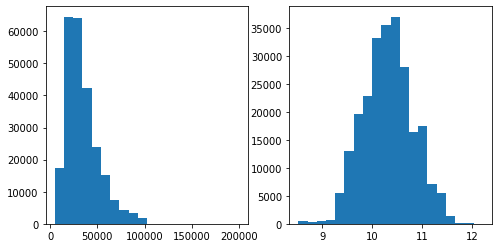

In [66]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float64')

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.hist(data['SalaryNormalized'], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.show()

In [67]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", 
                       "ContractType", "ContractTime", "SourceName"]
target_column = "Log1pSalary"

In [68]:
data[categorical_columns] = data[categorical_columns].fillna('NaN')

## Preprocessing text data
Tokenize `Title` and `FullDescription`. 

In [29]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [69]:
%%time
data["FullDescription"] = data['FullDescription'].apply(lambda s: ' '.join(tokenizer.tokenize(str(s).lower())))
data["Title"] = data['Title'].apply(lambda s: ' '.join(tokenizer.tokenize(str(s).lower())))

Wall time: 27.2 s


In [9]:
%%time
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

C:\Users\vlaser\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\vlaser\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Wall time: 6min 2s


In [10]:
def vectorize_sum(text):
    """
    implement a function that converts preprocessed
    comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    for token in text.split(' '):
        if token in embeddings.vocab:
            features += embeddings.get_vector(token)
    
    return features

In [ ]:
# %%time
# data['FullDescriptionEmb'] = data['FullDescription'].apply(lambda text: vectorize_sum(text))
# data['TitleEmb'] = data['Title'].apply(lambda text: vectorize_sum(text))

In [12]:
from collections import Counter

In [13]:
from sklearn.feature_extraction import DictVectorizer
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [14]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [15]:
def make_batch(data, max_len=None, word_dropout=0):
    batch = {}
    batch["Title"] = data['Title'].apply(lambda text: vectorize_sum(text))
    batch["FullDescription"] = data['FullDescription'].apply(lambda text: vectorize_sum(text))
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch


In [16]:
import keras
import keras.layers as L

Using TensorFlow backend.


In [22]:
def build_model(n_tokens=None, n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
#     l_title_emb = L.Embedding(n_tokens, hid_size, name='Title_emb')(l_title)
    l_title_conv = L.Convolution1D(filters=64, kernel_size=(3,), name='Title_conv')(l_title)

    l_title_pool = L.GlobalMaxPool1D(name='Title_pool')(l_title_conv)
    
#     l_descr_emb = L.Embedding(n_tokens, hid_size, name='Descr_emb')(l_descr)
    l_descr_conv = L.Convolution1D(filters=64, kernel_size=(3,), name='Descr_conv')(l_descr)

    l_descr_pool = L.GlobalMaxPool1D(name='Descr_pool')(l_descr_conv)

    l_cat_dense = L.Dense(hid_size, name='Categorical_dense')(l_categ)
    
    l_all = L.Concatenate()([l_title_pool, l_descr_pool, l_cat_dense])
    output_layer = L.Dense(1, name='Output_dense')(l_all)

    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [23]:
model = build_model()
model.summary()

ValueError: Input 0 is incompatible with layer Title_conv: expected ndim=3, found ndim=2

In [ ]:
dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [ ]:
batch_size = 256
epochs = 4            # definitely too small
steps_per_epoch = (len(data_train) - 1) // batch_size + 1  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [32]:
MAX_NUM_WORDS = 40000


In [33]:
ker_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

In [35]:
np.vstack([data['Title'], data['FullDescription']])

0    engineering systems analyst dorking surrey sal...
1    stress engineer glasgow salary **** to **** we...
Name: FullDescription, dtype: object

In [43]:
ker_tokenizer.fit_on_texts(np.concatenate([data['Title'], data['FullDescription']]))

In [70]:
title_seq = ker_tokenizer.texts_to_sequences(np.array(data['Title']))
descr_seq = ker_tokenizer.texts_to_sequences(np.array(data['FullDescription']))

In [46]:
word_index = ker_tokenizer.word_index

In [61]:
def pad_seq(sequences):
    max_len = 0
    for seq in sequences:
        if len(seq) > max_len:
            max_len = len(seq)

    return pad_sequences(sequences, max_len)

In [71]:
title_seq = pad_seq(title_seq)
descr_seq = pad_seq(descr_seq)

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
train_title, val_title, train_descr, val_descr, train_data, val_data = train_test_split(title_seq,
                                                                                        descr_seq,
                                                                                        data,
                                                                                       test_size=0.2,
                                                                                       random_state=42) 

In [78]:
train_data.shape, val_data.shape

((195814, 13), (48954, 13))

In [86]:
len(ker_tokenizer.word_counts.values())

200468

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time - our `L.GlobalMaxPool1D`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not want to use __`.get_keras_embedding()`__ method for word2vec
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback](https://keras.io/callbacks/#earlystopping).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!